In [2]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
tf.keras.backend.set_floatx('float64')

In [4]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'post'

In [5]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [6]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [7]:
agent.train(env,1000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition))

0 0.5035
1 0.5015
2 0.4998333333333333
3 0.49699999999999994
4 0.4997999999999999
5 0.49874999999999997
6 0.5022142857142857
7 0.5015624999999999
8 0.5015555555555555
9 0.50105
10 0.5016499999999999
11 0.50315
12 0.50365
13 0.50705
14 0.50765
15 0.5107
16 0.5112
17 0.51845
18 0.5237499999999999
19 0.5285500000000001
20 0.5323500000000001
21 0.5357000000000001
22 0.5428
23 0.5478500000000001
24 0.5519000000000001
25 0.5581
26 0.5621
27 0.563
28 0.563
29 0.5658
30 0.5702
31 0.5736
32 0.57505
33 0.5763
34 0.57885
35 0.5801000000000001
36 0.5793000000000001
37 0.5783000000000001
38 0.58265
39 0.5819500000000001
40 0.58165
41 0.5806
42 0.5811
43 0.5809499999999999
44 0.58185
45 0.5812999999999999
46 0.58475
47 0.58495
48 0.58515
49 0.58735
50 0.5866
51 0.5887
52 0.5884
53 0.5918000000000001
54 0.59385
55 0.5948
56 0.5953999999999999
57 0.59715
58 0.5981
59 0.6003
60 0.6037999999999999
61 0.6043499999999999
62 0.6052000000000001
63 0.6028
64 0.6009
65 0.6007499999999999
66 0.60205
67 0.60244

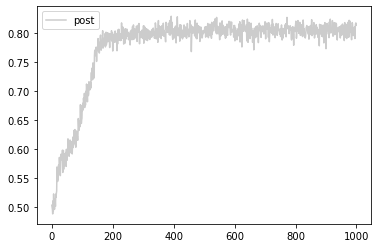

In [8]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [9]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [10]:
agent.load('UniversalRNN-'+str(condition))

LOADING ['nn', 'out_nn']


In [11]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [37]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1,2] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [38]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [39]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [48]:
out = agent.nn(batch_obs).numpy()#:,-1:,:]
choice = agent.predict(batch_obsf).numpy()

In [49]:
#Residue ref
#ref = batch_obsf.get('obs')[:,:,2:].reshape((-1,2))
#out = residue(out,ref)

#Residue choice
#choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
#out = residue(out, choice_batch)

In [50]:
#fit pca
pca = fit_pca(out.reshape((-1,50)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,50))).reshape(out.shape[:-1]+(nb_variance,))

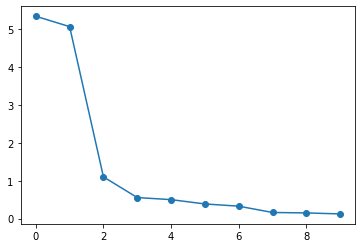

In [51]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [54]:
#Plot background function
def plot_bg(pca_batch,ax,zorder=0):
    
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    print(len(colors),pca_batch.shape)
    colors[-1] = 'black'
    for i in range(pca_batch.shape[1]):
        alpha = 0.1
        if i == len(colors)-1:
            alpha = 1
        ax.scatter(pca_batch[:,i,0],pca_batch[:,i,1],pca_batch[:,i,2],color=colors[i],alpha=alpha,marker='.',zorder=zorder)
#Returns a grid of the latent space (for categorisation field)
def get_batch_state(pca_batch,res=10,return_grid=False):
    axis_x = np.linspace(np.min(pca_batch[:,:,0]),np.max(pca_batch[:,:,0]),10)
    axis_y = np.linspace(np.min(pca_batch[:,:,1]),np.max(pca_batch[:,:,1]),10)
    axis_z =np.linspace(np.min(pca_batch[:,:,2]),np.max(pca_batch[:,:,2]),10)
    X,Y,Z = np.meshgrid(axis_x,axis_y,axis_z)
    M=np.concatenate([X[:,:,:,None],Y[:,:,:,None],Z[:,:,:,None]],axis=3)
    print(M.shape)
    Zr = np.reshape(M,(-1,3))

    proj_mat = pca.components_[pca_axes]

    Zrp = np.dot(Zr,proj_mat)

    batch_state = Zrp

    out = tf.convert_to_tensor(batch_state,dtype=tf.float64)
    if return_grid:
        return out,Zr
    return out
def plot_categorisation_field(pca_batch,ax,zorder=10):
    c = 0.1
    batch_state,grid = get_batch_state(pca_batch,return_grid=True)
    out_batch = agent.out_dense(batch_state)
    for k in range(out_batch.shape[0]):
        ax.plot([grid[k][0]],[grid[k][1]],[grid[k][2]],color='orange',marker='o',alpha=out_batch[k,0].numpy().item()*c,zorder=zorder)
        ax.plot([grid[k][0]],[grid[k][1]],[grid[k][2]],color='blue',marker='o',alpha=out_batch[k,1].numpy().item()*c,zorder=zorder)

13 (2000, 13, 10)
(10, 10, 10, 3)


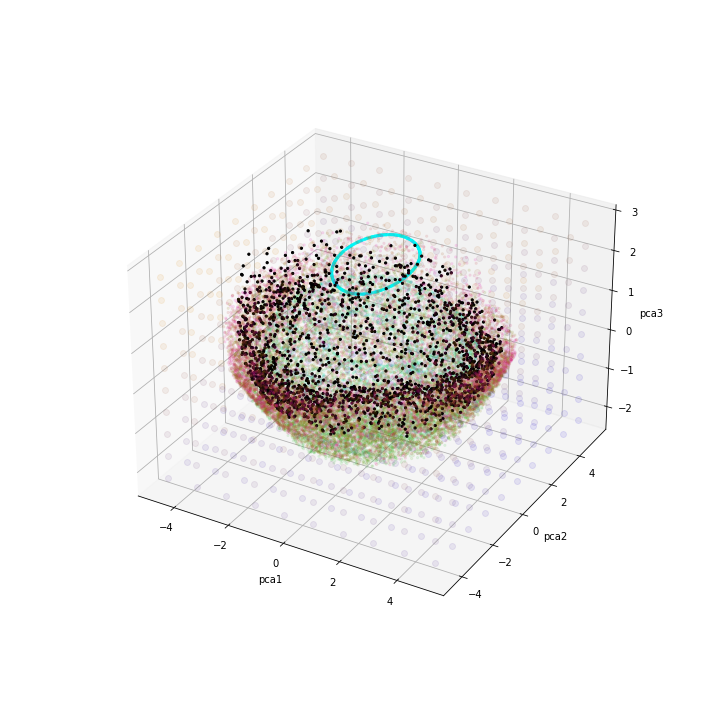

In [55]:
%matplotlib widget
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plot_bg(pca_batch,ax)
plot_categorisation_field(pca_batch,ax)
plt.show()